In [1]:
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv('/kaggle/input/emnist/emnist-byclass-train.csv', header=None)
test_data = pd.read_csv('/kaggle/input/emnist/emnist-byclass-test.csv', header=None)

In [3]:
train_data[0].value_counts

<bound method IndexOpsMixin.value_counts of 0         35
1         36
2          6
3          3
4         22
          ..
697927    40
697928    47
697929     5
697930    11
697931    22
Name: 0, Length: 697932, dtype: int64>

In [4]:
X_train = train_data.iloc[:, 1:].values /255
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values / 255.0
y_test = test_data.iloc[:, 0].values

In [5]:
img_size = X_train.shape[1]
num_classes = len(test_data[0].value_counts())
print(img_size, num_classes)

784 62


In [6]:
def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return (x > 0).astype(float)  


def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [7]:
def cross_entropy_loss(predictions, labels):
    n = labels.shape[0]
    predictions = np.clip(predictions, 1e-12, 1. - 1e-12)
    log_likelihood = -np.log(predictions[np.arange(n), np.argmax(labels, axis=1)])
    loss = np.sum(log_likelihood) / n
    return loss

def cross_entropy_gradient(predictions, labels):
    return predictions - labels

In [8]:
class DenseLayer:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.input = None
        self.output = None
        self.weights_grad = None
        self.bias_grad = None

    def forward(self, input_data):
        self.input = input_data
        self.output = np.dot(input_data, self.weights) + self.bias
        return self.output

    def backward(self, output_gradient, learning_rate):
        self.weights_grad = np.dot(self.input.T, output_gradient)
        self.bias_grad = np.sum(output_gradient, axis=0, keepdims=True)
        input_gradient = np.dot(output_gradient, self.weights.T)

        self.weights -= learning_rate * self.weights_grad
        self.bias -= learning_rate * self.bias_grad

        return input_gradient


class ActivationLayer:
    def __init__(self, activation, activation_derivative):
        self.activation = activation
        self.activation_derivative = activation_derivative
        self.input = None
        self.output = None

    def forward(self, input_data):
        self.input = input_data
        self.output = self.activation(input_data)
        return self.output

    def backward(self, output_gradient, learning_rate):
        return output_gradient * self.activation_derivative(self.input)


class ResidualBlock:
    def __init__(self, input_size, hidden_size):
        self.dense1 = DenseLayer(input_size, hidden_size)
        self.activation1 = ActivationLayer(relu, relu_derivative)
        self.dense2 = DenseLayer(hidden_size, input_size)
        self.activation2 = ActivationLayer(relu, relu_derivative)  
        self.input = None
        self.output = None

    def forward(self, input_data):
        self.input = input_data
        x = self.dense1.forward(input_data)
        x = self.activation1.forward(x)
        x = self.dense2.forward(x)
        self.output = self.activation2.forward(input_data + x)  #skip connection
        return self.output

    def backward(self, output_gradient, learning_rate):
        x_grad = self.activation2.backward(output_gradient, learning_rate)
        x_grad = self.dense2.backward(x_grad, learning_rate)
        x_grad = self.activation1.backward(x_grad, learning_rate)
        x_grad = self.dense1.backward(x_grad, learning_rate)
        return x_grad + output_gradient

In [9]:
class ResNet:

    def __init__(self, input_size, num_classes, num_residual_blocks):
        
        self.dense1 = DenseLayer(input_size, 256)
        self.activation1 = ActivationLayer(relu, relu_derivative)
        self.residual_blocks = [ResidualBlock(256, 64) for _ in range(num_residual_blocks)]
        self.dense2 = DenseLayer(256, num_classes)
        self.layers = [self.dense1, self.activation1] + self.residual_blocks + [self.dense2]


    def forward(self, x):
       
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, output_gradient, learning_rate):

        for layer in reversed(self.layers):
            output_gradient = layer.backward(output_gradient, learning_rate)

    def predict(self, x):
     
        output = self.forward(x)
        return np.argmax(softmax(output), axis=1)


    def train_step(self, batch_images, batch_labels, learning_rate):
      
        # Forward pass
        output = self.forward(batch_images)
        predictions = softmax(output)

        # Calculate loss
        loss = cross_entropy_loss(predictions, batch_labels)

        # Backward pass
        gradient = cross_entropy_gradient(predictions, batch_labels)
        self.backward(gradient, learning_rate)

        return loss


    def train(self, train_images, train_labels, epochs, batch_size, learning_rate):
        num_samples = train_images.shape[0]
        input_size = train_images.shape[1]
        num_classes = len(np.unique(train_labels))
        self.loss_history = []
        train_labels_encoded = np.eye(num_classes)[train_labels] #encoding the training labels

        for epoch in range(epochs):
            epoch_loss = 0.0
            for i in range(0, num_samples, batch_size):
                batch_images = train_images[i:i + batch_size]
                batch_labels = train_labels_encoded[i:i + batch_size]

                loss = self.train_step(batch_images, batch_labels, learning_rate)
                epoch_loss += loss
                
            epoch_loss_avg = epoch_loss / (num_samples / batch_size)
            self.loss_history.append(epoch_loss_avg)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / (num_samples / batch_size):.4f}")
                
        
                
                
    def evaluate(self, test_images, test_labels):
    
        predictions = self.predict(test_images)
        accuracy = np.mean(predictions == test_labels)
        return accuracy

In [10]:
img_size = X_train.shape[1]
num_classes = len(test_data[0].value_counts())
batch_size = 64
learning_rate = 0.001
epochs = 10
residual_blocks = 5 

In [11]:
model = ResNet(img_size, num_classes, residual_blocks)

In [12]:
X_train.shape, y_train.shape

((697932, 784), (697932,))

In [13]:
model.train(X_train, y_train, epochs, batch_size, learning_rate)

Epoch 1/10, Loss: 0.8362
Epoch 2/10, Loss: 0.4976
Epoch 3/10, Loss: 0.4474
Epoch 4/10, Loss: 0.4217
Epoch 5/10, Loss: 0.4048
Epoch 6/10, Loss: 0.3921
Epoch 7/10, Loss: 0.3822
Epoch 8/10, Loss: 0.3740
Epoch 9/10, Loss: 0.3671
Epoch 10/10, Loss: 0.3608


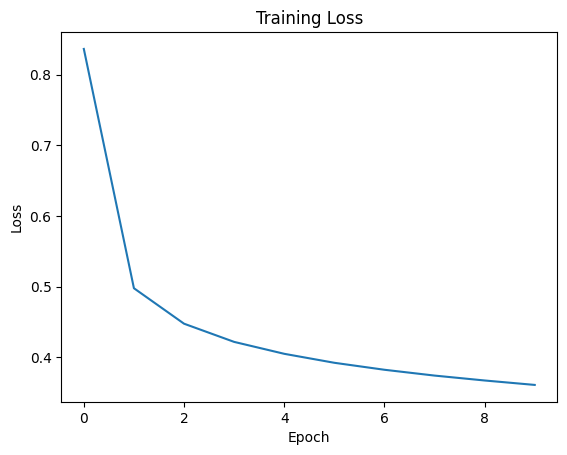

In [14]:
import matplotlib.pyplot as plt

plt.plot(model.loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [26]:
y_pred = model.predict(X_test)

In [27]:
y_pred.shape, y_test.shape

((116323,), (116323,))

In [29]:
from sklearn.metrics import precision_score, f1_score
accuracy = model.evaluate(X_test, y_test)*100
precision = precision_score(y_test, y_pred, average='weighted')*100
f1_scr  = f1_score(y_test, y_pred, average='weighted')*100

In [31]:
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"F1 Score: {f1_scr:.2f}%")

Accuracy: 85.03%
Precision: 83.99%
F1 Score: 83.69%
